<a href="https://colab.research.google.com/github/jagadeep31/Learn-Flow-Task1-fraud_detection-/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing the dataset using dask
%time dataset = pd.read_csv('online_fraud.csv')
print('Shape:',dataset.shape)


CPU times: user 9.93 ms, sys: 8.94 ms, total: 18.9 ms
Wall time: 24.5 ms
Shape: (3580, 11)


In [4]:
#checking how many frauds are there
print(dataset['isFraud'].value_counts())
dataset['type'].value_counts()

0    3558
1      22
Name: isFraud, dtype: int64


PAYMENT     1872
CASH_IN      657
CASH_OUT     487
TRANSFER     355
DEBIT        209
Name: type, dtype: int64

In [6]:
# finding  out the types of fraudulent transaction types out of all the transaction modes.
print('The Types of fraudulent transactions are {}'.format(list(dataset.loc[dataset.isFraud == 1].type.drop_duplicates().values)))

The Types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']


In [7]:
# making dependent and independent sets
X = dataset.loc[(dataset.type == 'TRANSFER') | (dataset.type == 'CASH_OUT')]
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [8]:
# feature engg.
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

<ipython-input-8-68afd7e53e61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
<ipython-input-8-68afd7e53e61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest


In [9]:
# removing unwanted columns
X = X.drop(['nameDest','nameOrig'], axis = 1)

# checking the new shape of data
print("Shape:",X.shape)

Shape: (842, 11)


In [10]:
# label encoding for the transaction type
X['type'].replace('TRANSFER', 0, inplace = True)
X['type'].replace('CASH_OUT', 1, inplace = True)
print(X.head())
print(X.isnull().any().any())

    step  type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1     0     181.00          181.0             0.0             0.0   
3      1     1     181.00          181.0             0.0         21182.0   
15     1     1  229133.94        15325.0             0.0          5083.0   
19     1     0  215310.30          705.0             0.0         22425.0   
24     1     0  311685.89        10835.0             0.0          6267.0   

    newbalanceDest  isFraud  isFlaggedFraud  errorBalanceOrig  \
2             0.00        1               0              0.00   
3             0.00        1               0              0.00   
15        51513.44        0               0         213808.94   
19            0.00        0               0         214605.30   
24      2719172.89        0               0         300850.89   

    errorBalanceDest  
2              181.0  
3            21363.0  
15          182703.5  
19          237735.3  
24        -2401220.0  
False


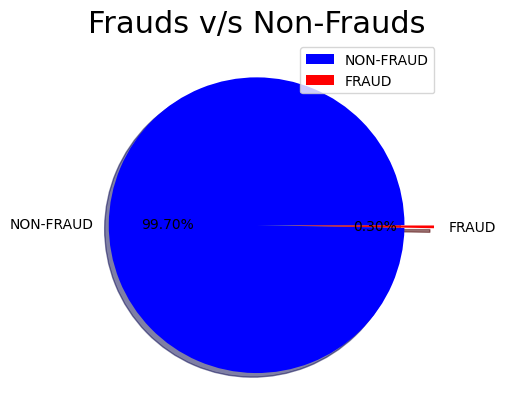

In [11]:
# plotting a pie chart to represent the fraction of the frauds
size = [2762196, 8213]
labels = ['NON-FRAUD', 'FRAUD']
colors = ['blue', 'red']
explode = [0, 0.2]
plt.pie(size, labels = labels, colors = colors, explode = explode, shadow  = True, autopct = '%.2f%%')
plt.title('Frauds v/s Non-Frauds', fontsize = 22)
plt.axis('off')
plt.legend()
plt.show()

In [12]:
# making our independent set
Y = X['isFraud']

# removing the dependent set
X = X.drop(['isFraud'], axis = 1)

# getting the shapes of x and y
print("Shape of x: ", X.shape)
print("Shape of y: ", Y.shape)

Shape of x:  (842, 10)
Shape of y:  (842,)


In [13]:
# splitting the dataset into train and tests
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)

# checking the new shapes
print("Shape of x_train: ", x_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

# performing standard scaling on the data for better fit
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Shape of x_train:  (673, 10)
Shape of x_test:  (169, 10)
Shape of y_train:  (673,)
Shape of y_test:  (169,)


In [14]:
# Using XGBOOST
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import average_precision_score
model = XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# score of the model
auprc = average_precision_score(y_test, y_pred)
print("The Area under Precision Recall Curve Score is", auprc)

# looking at the confusion matrix
from sklearn.metrics import confusion_matrix
ConfusionMatrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix :\n")
print(ConfusionMatrix)

The Area under Precision Recall Curve Score is 1.0
Confusion Matrix :

[[166   0]
 [  0   3]]
